In [34]:
import requests
import pandas as pd
import numpy as np
data = pd.read_csv("https://raw.githubusercontent.com/rashida048/Datasets/master/home_data.csv")
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

## Exploratory Data Analysis

In [2]:
data = data[['price','date','bedrooms','bathrooms','sqft_living','condition','yr_built']]

In [3]:
import datetime
date_fixed = []
for i in data['date'].values:
    val = datetime.datetime.strptime(i[:8],'%Y%m%d')
    date_fixed.append(val.year + val.month/12)

date_fixed = np.array(date_fixed)   

In [4]:
data['date_new'] = date_fixed - min(date_fixed)

In [5]:
data['price/sqft'] = data['price']/data['sqft_living']

In [6]:
data['years since built'] = min(date_fixed) +data['date_new'] - data['yr_built'].astype(float) 

In [7]:
data_cleaned = data[['price','bedrooms','bathrooms','condition','date_new','years since built','sqft_living']]

In [8]:
data_cleaned.describe()

,price,bedrooms,bathrooms,condition,date_new,years since built,sqft_living
count,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.400881e+05,3.370842,2.114757,3.409430,0.454156,43.865687,2079.899736
std,3.671272e+05,0.930062,0.770163,0.650743,0.310003,29.375023,918.440897
min,7.500000e+04,0.000000,0.000000,1.000000,0.000000,-0.583333,290.000000
25%,3.219500e+05,3.000000,1.750000,3.000000,0.166667,18.250000,1427.000000
50%,4.500000e+05,3.000000,2.250000,3.000000,0.416667,40.083333,1910.000000
75%,6.450000e+05,4.000000,2.500000,4.000000,0.750000,63.416667,2550.000000
max,7.700000e+06,33.000000,8.000000,5.000000,1.000000,115.416667,13540.000000


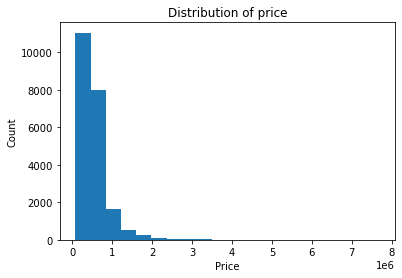

In [9]:
import matplotlib.pyplot as plt
plt.hist(data_cleaned['price'],bins=20)
plt.title("Distribution of price")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

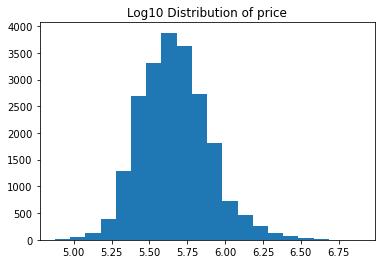

In [10]:
plt.hist(np.log10(data_cleaned['price']),bins=20)
plt.title("Log10 Distribution of price")
plt.show()

In [11]:
vals, counts = np.unique(data['bedrooms'],return_counts = True)

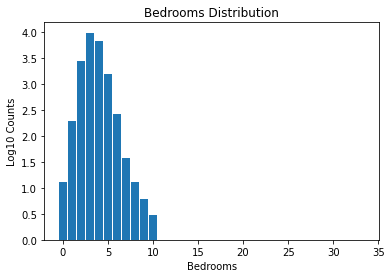

In [35]:
vals, counts = np.unique(data['bedrooms'],return_counts = True)
plt.bar(vals,np.log10(counts))
plt.title("Bedrooms Distribution")
plt.xlabel("Bedrooms")
plt.ylabel("Log10 Counts")
plt.show()

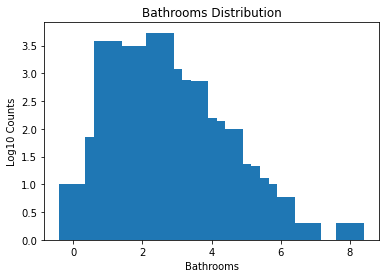

In [13]:
vals, counts = np.unique(data['bathrooms'],return_counts = True)
plt.bar(vals,np.log10(counts))
plt.title("Bathrooms Distribution")
plt.xlabel("Bathrooms")
plt.ylabel("Log10 Counts")
plt.show()

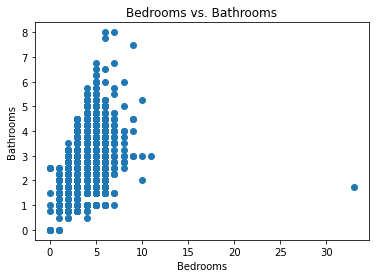

In [14]:
plt.scatter(data['bedrooms'],data['bathrooms'])
plt.xlabel("Bedrooms")
plt.ylabel("Bathrooms")
plt.title("Bedrooms vs. Bathrooms")
plt.show()

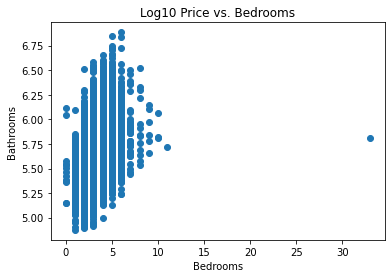

In [15]:
plt.scatter(data['bedrooms'],np.log10(data_cleaned['price']))
plt.title("Log10 Price vs. Bedrooms")
plt.xlabel("Bedrooms")
plt.ylabel("Bathrooms")
plt.show()


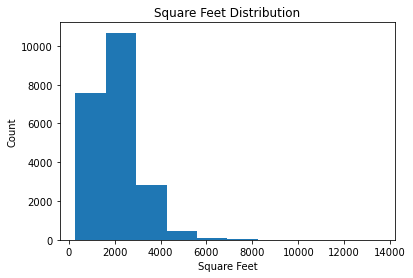

In [16]:
plt.hist(data['sqft_living'])
plt.title("Square Feet Distribution")
plt.xlabel("Square Feet")
plt.ylabel("Count")
plt.show()

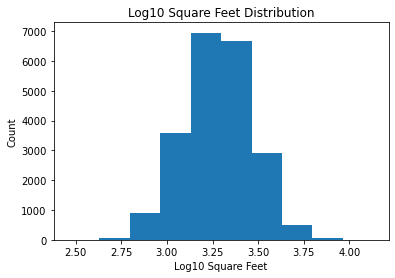

In [17]:
plt.hist(np.log10(data['sqft_living']))
plt.title("Log10 Square Feet Distribution")
plt.xlabel("Log10 Square Feet")
plt.ylabel("Count")
plt.show()

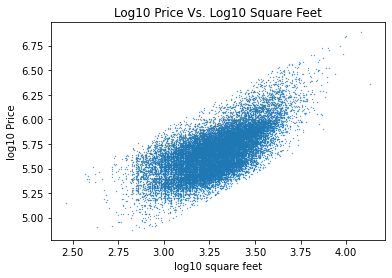

In [18]:
plt.scatter(np.log10(data['sqft_living']),np.log10(data['price']),s=.1)
plt.xlabel("log10 square feet")
plt.ylabel("log10 Price")
plt.title("Log10 Price Vs. Log10 Square Feet")
plt.show()


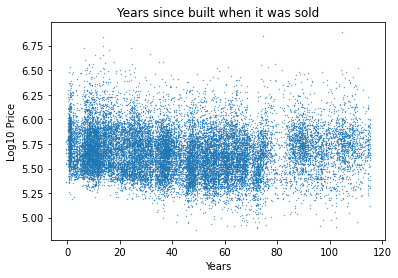

In [19]:
plt.scatter(data['years since built'],np.log10(data['price']),s=.1)
plt.title("Years since built when it was sold")
plt.xlabel("Years")
plt.ylabel("Log10 Price")
plt.show()

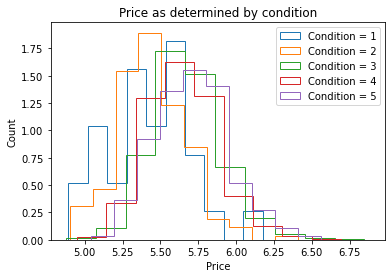

In [36]:
plt.hist(np.log10(data[data['condition']==1]['price']),density=True,histtype='step',label='Condition = 1')
plt.hist(np.log10(data[data['condition']==2]['price']),density=True,histtype='step',label='Condition = 2')
plt.hist(np.log10(data[data['condition']==3]['price']),density=True,histtype='step',label='Condition = 3')
plt.hist(np.log10(data[data['condition']==4]['price']),density=True,histtype='step',label='Condition = 4')
plt.hist(np.log10(data[data['condition']==5]['price']),density=True,histtype='step',label='Condition = 5')
plt.legend()
plt.title("Price as determined by condition")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

## Linear Model Building

**Borrowed code from introduction to data science class in JHU program to build Linear model and yield R^2**

In [37]:
import numpy as np
import scipy.stats as stats
import patsy
import sklearn.linear_model as linear
import random
import pandas as pd
from pprint import pprint

# we're not currently using this because the LaTeX
# experience is so awful (it doesn't use HTML but
# the plaintext representation).
from IPython.display import HTML, display_html
from tabulate import tabulate

ALGORITHMS = {
    "linear": linear.LinearRegression,
    "ridge": linear.Ridge,
    "lasso": linear.Lasso
}

def summarize(formula, X, y, model, style='linear'):
    result = {}
    result["formula"] = formula
    result["n"] = len(y)
    result["model"] = model
    # I think this is a bug in Scikit Learn 
    # because lasso should work with multiple targets.
    if style == "lasso":
        result["coefficients"] = model.coef_
    else:
        result["coefficients"] =  model.coef_[0]
    result["r_squared"] = model.score( X, y)
    y_hat = model.predict(X)
    result["residuals"] = y - y_hat
    result["y_hat"] = y_hat
    result["y"]  = y
    sum_squared_error = sum([e**2 for e in result[ "residuals"]])[0]

    n = len(result["residuals"])
    k = len(result["coefficients"])
    
    result["sigma"] = np.sqrt( sum_squared_error / (n - k))
    return result

def linear_regression(formula, data=None, style="linear", params={}):
    if data is None:
        raise ValueError( "The parameter 'data' must be assigned a non-nil reference to a Pandas DataFrame")

    params["fit_intercept"] = False

    y, X = patsy.dmatrices(formula, data, return_type="matrix")
    algorithm = ALGORITHMS[style]
    algo = algorithm(**params)
    model = algo.fit( X, y)

    result = summarize(formula, X, y, model, style)

    return result

def logistic( z):
    return 1.0 / (1.0 + np.exp( -z))

def logistic_regression( formula, data=None):
    if data is None:
        raise ValueError( "The parameter 'data' must be assigned a non-nil reference to a Pandas DataFrame")

    result = {}
    result[ "formula"] = formula
    result[ "n"] = data.shape[ 0]

    y, X = patsy.dmatrices( formula, data, return_type="matrix")
    y = np.ravel( y) # not sure why this is needed for LogisticRegression but not LinearRegression

    model = linear.LogisticRegression( fit_intercept=False).fit( X, y)
    result["model"] = model

    result[ "coefficients"] = model.coef_[ 0]

    y_hat = model.predict( X)
    result[ "residuals"] = y - y_hat
    result["y_hat"] = y_hat 
    result["y"] = y

    # efron's pseudo R^2
    y_bar = np.mean(y)
    pr = model.predict_proba(X).transpose()[1]
    result["probabilities"] = pr
    efrons_numerator = np.sum((y - pr)**2) 
    efrons_denominator = np.sum((y-y_bar)**2)
    result["r_squared"] = 1 - (efrons_numerator/efrons_denominator)

    # error rate
    result["sigma"] = np.sum(np.abs(result["residuals"]))/result["n"]*100

    n = len( result[ "residuals"])
    k = len( result[ "coefficients"])

    return result

def bootstrap_linear_regression( formula, data=None, samples=100, style="linear", params={}):
    if data is None:
        raise ValueError( "The parameter 'data' must be assigned a non-nil reference to a Pandas DataFrame")
    
    bootstrap_results = {}
    bootstrap_results[ "formula"] = formula

    variables = [x.strip() for x in formula.split("~")[1].split( "+")]
    variables = ["intercept"] + variables
    bootstrap_results[ "variables"] = variables
    
    coeffs = []
    sigmas = []
    rs = []

    n = len(data)
    bootstrap_results[ "n"] = n
    
    for i in range( samples):
        sampling = data.sample(len(data), replace=True)
        results = linear_regression( formula, data=sampling, style=style, params=params)
        coeffs.append( results[ "coefficients"])
        sigmas.append( results[ "sigma"])
        rs.append( results[ "r_squared"])
    
    coeffs = pd.DataFrame( coeffs, columns=variables)
    sigmas = pd.Series( sigmas, name="sigma")
    rs = pd.Series( rs, name="r_squared")

    bootstrap_results[ "resampled_coefficients"] = coeffs
    bootstrap_results[ "resampled_sigma"] = sigmas
    bootstrap_results[ "resampled_r^2"] = rs
    
    result = linear_regression( formula, data=data)
    
    bootstrap_results[ "residuals"] = result[ "residuals"]
    bootstrap_results[ "coefficients"] = result[ "coefficients"]
    bootstrap_results[ "sigma"] = result[ "sigma"]
    bootstrap_results[ "r_squared"] = result[ "r_squared"]
    bootstrap_results["model"] = result["model"]
    bootstrap_results["y"] = result["y"]
    bootstrap_results["y_hat"] = result["y_hat"]
    return bootstrap_results

def bootstrap_logistic_regression( formula, data=None, samples=100):
    if data is None:
        raise ValueError( "The parameter 'data' must be assigned a non-nil reference to a Pandas DataFrame")
    
    bootstrap_results = {}
    bootstrap_results[ "formula"] = formula

    variables = [x.strip() for x in formula.split("~")[1].split( "+")]
    variables = ["intercept"] + variables
    bootstrap_results[ "variables"] = variables
    
    coeffs = []
    sigmas = []
    rs = []

#    n = data.shape[ 0]
    n = len(data)
    bootstrap_results[ "n"] = n
    
    for i in range( samples):
        sampling = data.sample(n, replace=True)
        results = logistic_regression( formula, data=sampling)
        coeffs.append( results[ "coefficients"])
        sigmas.append( results[ "sigma"])
        rs.append( results[ "r_squared"])
    
    coeffs = pd.DataFrame( coeffs, columns=variables)
    sigmas = pd.Series( sigmas, name="sigma")
    rs = pd.Series( rs, name="r_squared")

    bootstrap_results[ "resampled_coefficients"] = coeffs
    bootstrap_results[ "resampled_sigma"] = sigmas
    bootstrap_results[ "resampled_r^2"] = rs
    
    result = logistic_regression( formula, data=data)
    
    bootstrap_results[ "residuals"] = result[ "residuals"]
    bootstrap_results[ "coefficients"] = result[ "coefficients"]
    bootstrap_results[ "sigma"] = result[ "sigma"]
    bootstrap_results[ "r_squared"] = result[ "r_squared"]
    bootstrap_results["model"] = result["model"]
    return bootstrap_results

def fmt(n, sd=2):
    return (r"{0:." + str(sd) + "f}").format(n)


def boldify(xs, format):
    if format == "html":
        return ["<strong>" + x + "</strong>" if x != "" else "" for x in xs]
    if format == "markdown":
        return ["**" + x + "**" if x != "" else "" for x in xs]
    # latex
    return ["\\textbf{" + x + "}" if x != "" else "" for x in xs]


def results_table(fit, sd=2,bootstrap=False, is_logistic=False, format="html"):
    result = {} 
    result["model"] = [fit["formula"]]

    variables = [v.strip() for v in [""] + fit["formula"].split("~")[1].split( "+")]
    if format == 'latex':
        variables = [v.replace("_", "\\_") for v in variables]
    coefficients = [] 

    if bootstrap:
        bounds = fit[ "resampled_coefficients"].quantile([0.025, 0.975])
        bounds = bounds.transpose()
        bounds = bounds.values.tolist()
        for i, b in enumerate(zip(variables, fit["coefficients"], bounds)):
            if format == "latex":
                coefficient = [b[0], f"\\(\\beta_{{{i}}}\\)", fmt(b[1], sd), fmt(b[2][0], sd), fmt(b[2][1], sd)]                
            else:
                coefficient = [b[0], f"$\\beta_{{{i}}}$", fmt(b[1], sd), fmt(b[2][0], sd), fmt(b[2][1], sd)]
            if is_logistic:
                if i == 0:
                    coefficient.append(fmt(logistic(b[1]), sd))
                else:
                    coefficient.append(fmt(b[1]/4, sd))
            coefficients.append(coefficient)
    else:
        for i, b in enumerate(zip(variables, fit["coefficients"])):
            if format == "latex":
                coefficients.append([b[0], f"\\(\\beta_{{{i}}}\\)", fmt(b[1], sd)])
            else:
                coefficients.append([b[0], f"$\\beta_{{{i}}}$", fmt(b[1], sd)])
    result["coefficients"] = coefficients

    error = r"\(\sigma\)" if format == "latex" else r"$\sigma$"
    r_label = r"\(R^2\)" if format == "latex" else r"$R^2$"
    if is_logistic:
        error = "Error (%)"
        r_label = r"Efron's \(R^2\)" if format == "latex" else r"Efron's $R^2$"
    if bootstrap:
        sigma_bounds = stats.mstats.mquantiles( fit[ "resampled_sigma"], [0.025, 0.975])
        r_bounds = stats.mstats.mquantiles( fit[ "resampled_r^2"], [0.025, 0.975])
        metrics = [
            [error, fmt(fit["sigma"], sd), fmt(sigma_bounds[0], sd), fmt(sigma_bounds[1], sd)], 
            [r_label, fmt(fit["r_squared"], sd), fmt(r_bounds[0], sd), fmt(r_bounds[1], sd)]]
    else:
        metrics = [
            [error, fmt(fit["sigma"], sd)], 
            [r_label, fmt(fit["r_squared"], sd)]]

    result["metrics"] = metrics

    title = f"Model: {result['model'][0]}"
    rows = []
    if bootstrap:
        rows.append(boldify(["", "", "", "95% BCI"], format))
    if is_logistic:
        if bootstrap:
            header = boldify(["Coefficients", "", "Mean", "Lo", "Hi", "P(y=1)"], format)
        else:
            header = boldify(["Coefficients", "", "Value"], format)
    else:
        if bootstrap:
            header = boldify(["Coefficients", "", "Mean", "Lo", "Hi"], format)
        else:
            header = boldify(["Coefficients", "", "Value"], format)
    rows.append(header)

    for row in result["coefficients"]:
        rows.append(row)

    rows.append([])

    if bootstrap:
        rows.append(boldify(["Metrics", "Mean", "Lo", "Hi"], format))
    else:
        rows.append(boldify(["Metrics", "Value"], format))
    for row in result["metrics"]:
        rows.append(row)

    return title, rows


class ResultsWrapper(object):
    def __init__(self, fit, sd=4, bootstrap=False, is_logistic=False):
        self.fit = fit
        self.sd = sd
        self.bootstrap = bootstrap
        self.is_logistic = is_logistic

    def _repr_markdown_(self):
        title, table = results_table(self.fit, self.sd, self.bootstrap, self.is_logistic, format="markdown")
        table = tabulate(table, tablefmt="github")
        markdown = title + "\n" + table
        return markdown

    def _repr_html_(self):
        title, table = results_table(self.fit, self.sd, self.bootstrap, self.is_logistic, format="html")
        table = tabulate(table, tablefmt="html")
        table = table.replace("&lt;strong&gt;", "<strong>").replace("&lt;/strong&gt;", "</strong")
        return f"<p><strong>{title}</strong><br/>{table}</p>"

    def _repr_latex_(self):
        title, table = results_table(self.fit, self.sd, self.bootstrap, self.is_logistic, format="latex")

        title = title.replace("~", "\\(\\sim\)").replace("_", "\\_")

        table = tabulate(table, tablefmt="latex_booktabs")
#        table = tabulate(table, tablefmt="latex_longtable")
#        table = tabulate(table, tablefmt="latex_raw")
        table = table.replace("textbackslash{}", "").replace("\^{}", "^").replace("\_", "_")
        table = table.replace("\\$", "$").replace("\\{", "{").replace("\\}", "}")
        latex = "\\textbf{" + title + "}\n\n" + table
        return latex


def print_csv(table):
    print("Linear Regression")
    print("Coefficients")
    for item in table["coefficients"]:
        print(','.join(item))
    print("Metrics")
    for item in table["metrics"]:
        print(','.join(item))
    
def simple_describe_lr(fit, sd=2):
    return ResultsWrapper(fit, sd)

def simple_describe_lgr(fit, sd=2):
    return ResultsWrapper(fit, sd, False, True)

def describe_bootstrap_lr(fit, sd=2):
    return ResultsWrapper(fit, sd, True, False)

def describe_bootstrap_lgr(fit, sd=2):
    return ResultsWrapper(fit, sd, True, True)

def strength(pr):
    if 0 <= pr <= 0.33:
        return "weak"
    if 0.33 < pr <= 0.66:
        return "mixed"
    return "strong"

# {"var1": "+", "var2": "-"}
def evaluate_coefficient_predictions(predictions, result):
    coefficients = result["resampled_coefficients"].columns
    for coefficient in coefficients:
        if coefficient == 'intercept':
            continue
        if predictions[coefficient] == '+':
            pr = np.mean(result["resampled_coefficients"][coefficient] > 0)
            print("{0} P(>0)={1:.3f} ({2})".format(coefficient, pr, strength(pr)))
        else:
            pr = np.mean(result["resampled_coefficients"][coefficient] < 0)
            print("{0} P(<0)={1:.3f} ({2})".format(coefficient, pr, strength(pr)))

def adjusted_r_squared(result):
    adjustment = (result["n"] - 1)/(result["n"] - len(result["coefficients"]) - 1 - 1)
    return 1 - (1 - result["r_squared"]) * adjustment

In [22]:
def correlations(data, y, xs):
    rs = []
    rhos = []
    for x in xs:
        r = stats.pearsonr(data[y], data[x])[0]
        rs.append(r)
        rho = stats.spearmanr(data[y], data[x])[0]
        rhos.append(rho)
    return pd.DataFrame({"feature": xs, "r": rs, "rho": rhos})

In [23]:
data['price log'] = np.log10(data['price'])
#data['sqft log'] = np.log10(data['sqft'])
data

,price,date,bedrooms,bathrooms,sqft_living,condition,yr_built,date_new,price/sqft,years since built,price log
0,221900,20141013T000000,3,1.00,1180,3,1955,0.416667,188.050847,59.833333,5.346157
1,538000,20141209T000000,3,2.25,2570,3,1951,0.583333,209.338521,64.000000,5.730782
2,180000,20150225T000000,2,1.00,770,3,1933,0.750000,233.766234,82.166667,5.255273
3,604000,20141209T000000,4,3.00,1960,5,1965,0.583333,308.163265,50.000000,5.781037
4,510000,20150218T000000,3,2.00,1680,3,1987,0.750000,303.571429,28.166667,5.707570
...,...,...,...,...,...,...,...,...,...,...,...
21608,360000,20140521T000000,3,2.50,1530,3,2009,0.000000,235.294118,5.416667,5.556303
21609,400000,20150223T000000,4,2.50,2310,3,2014,0.750000,173.160173,1.166667,5.602060
21610,402101,20140623T000000,2,0.75,1020,3,2009,0.083333,394.216667,5.500000,5.604335
21611,400000,20150116T000000,3,2.50,1600,3,2004,0.666667,250.000000,11.083333,5.602060


In [24]:
data['price_log'] = np.log10(data['price'])
data['sqft_log'] = np.log10(data['sqft_living'])
data['years_since_built'] = data['years since built']

correlations(data, "price log", ['bedrooms', 'bathrooms', 'sqft_log', 'condition',
  'date_new', 'years since built'])

,feature,r,rho
0,bedrooms,0.343561,0.344652
1,bathrooms,0.550802,0.497160
2,sqft_log,0.674913,0.644191
3,condition,0.039558,0.018490
4,date_new,-0.003954,-0.008799
5,years since built,-0.080692,-0.102065


In [25]:
linear_model = "price_log ~ bedrooms + bathrooms + sqft_log + condition + date_new + years_since_built"
result1 = linear_regression(linear_model, data=data)
vals = simple_describe_lr(result1)

In [26]:
data

,price,date,bedrooms,bathrooms,sqft_living,condition,yr_built,date_new,price/sqft,years since built,price log,price_log,sqft_log,years_since_built
0,221900,20141013T000000,3,1.00,1180,3,1955,0.416667,188.050847,59.833333,5.346157,5.346157,3.071882,59.833333
1,538000,20141209T000000,3,2.25,2570,3,1951,0.583333,209.338521,64.000000,5.730782,5.730782,3.409933,64.000000
2,180000,20150225T000000,2,1.00,770,3,1933,0.750000,233.766234,82.166667,5.255273,5.255273,2.886491,82.166667
3,604000,20141209T000000,4,3.00,1960,5,1965,0.583333,308.163265,50.000000,5.781037,5.781037,3.292256,50.000000
4,510000,20150218T000000,3,2.00,1680,3,1987,0.750000,303.571429,28.166667,5.707570,5.707570,3.225309,28.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,360000,20140521T000000,3,2.50,1530,3,2009,0.000000,235.294118,5.416667,5.556303,5.556303,3.184691,5.416667
21609,400000,20150223T000000,4,2.50,2310,3,2014,0.750000,173.160173,1.166667,5.602060,5.602060,3.363612,1.166667
21610,402101,20140623T000000,2,0.75,1020,3,2009,0.083333,394.216667,5.500000,5.604335,5.604335,3.008600,5.500000
21611,400000,20150116T000000,3,2.50,1600,3,2004,0.666667,250.000000,11.083333,5.602060,5.602060,3.204120,11.083333


In [27]:
result1['coefficients']

array([ 2.78185774e+00, -4.13670511e-02,  7.51206259e-02,  8.38293056e-01,
        6.76294643e-03,  1.72369753e-02,  1.95164957e-03])

In [28]:
vals

Coefficients</strong,,Value</strong
,$\beta_{0}$,2.78
bedrooms,$\beta_{1}$,-0.04
bathrooms,$\beta_{2}$,0.08
sqft_log,$\beta_{3}$,0.84
condition,$\beta_{4}$,0.01
date_new,$\beta_{5}$,0.02
years_since_built,$\beta_{6}$,0.00
,,
Metrics</strong,Value</strong,
$\sigma$,0.16,


### Bayesian Analysis

This is Done after running the R file to yield file.txt

In [29]:
with open('file.txt') as f:
    lines = f.readlines()

In [30]:
lines

[' 0.5150913\n',
 ' [379] 0.5181467 0.5221716 0.5195037 0.5186527 0.5175627 0.5205947 0.5199423\n',
 ' [386] 0.5165840 0.5159612 0.5225681 0.5220418 0.5181203 0.5207679 0.5143595\n',
 ' [393] 0.5187521 0.5181359 0.5175882 0.5180320 0.5181600 0.5217780 0.5153256\n',
 ' [400] 0.5177856 0.5157813 0.5213621 0.5092488 0.5227603 0.5152123 0.5178839\n',
 ' [407] 0.5155140 0.5200541 0.5200703 0.5183479 0.5217623 0.5180400 0.5159301\n',
 ' [414] 0.5179421 0.5143083 0.5191267 0.5177862 0.5205407 0.5211633 0.5219042\n',
 ' [421] 0.5180721 0.5231138 0.5261182 0.5174169 0.5214833 0.5188681 0.5195953\n',
 ' [428] 0.5157899 0.5142393 0.5183026 0.5195604 0.5142106 0.5234500 0.5110425\n',
 ' [435] 0.5232602 0.5149031 0.5156049 0.5210042 0.5210693 0.5070784 0.5203921\n',
 ' [442] 0.5169012 0.5170225 0.5188850 0.5159166 0.5170185 0.5199720 0.5191657\n',
 ' [449] 0.5078060 0.5133002 0.5126138 0.5154096 0.5193411 0.5180934 0.5246568\n',
 ' [456] 0.5192321 0.5180874 0.5200077 0.5167252 0.5162870 0.5212974 0

In [32]:
full_vals = []
for i in lines[:-1]:
    for j in i.split(" "):
        if '.' in j:
            if '\n' in j:
                full_vals.append(float(j[:-1]))
            else:
                full_vals.append(float(j))
            
            

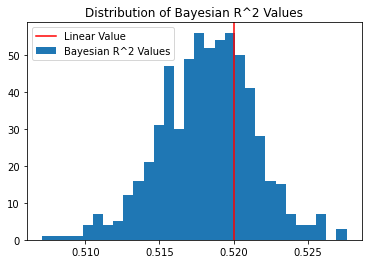

In [33]:
plt.hist(full_vals,bins=30,label='Bayesian R^2 Values')
plt.title("Distribution of Bayesian R^2 Values")
plt.axvline(.52,label="Linear Value",c='red')
plt.legend()
plt.show()